\noindent __Erwann Rault__  
_Centre Oscar Lambret (Lille)_

In [1]:
# DRAW MATPLOTLIB IN NOTEBOOK #

%matplotlib inline
# %matplotlib notebook


In [2]:
# LIBRARIES #

import numpy as np
import dicom as dcm
import matplotlib.pyplot as plt
import math
import time
import datetime

from scipy import ndimage
from ipywidgets import *

from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from os.path import basename

import warnings
warnings.filterwarnings('ignore')


In [3]:
# LAYOUT DEFINITIONS #

box_layout_std = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-start',
                    width='100%')

box_layout_right = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-end',
                    border='solid 0.5px #EEE',
                    width='100%')


In [195]:
# INPUT VARIABLES #

FILEPATH = 'X:/Med Nuc/etudes/SUVcalFactor_D670/Tc99m/tomo/fantomeSUV/2017.05.03/tomo2/qmetrix transaxials/Tomo2_EM_IRACSCRR001_DS.dcm'

Ainj = 185.74 #MBq
Tinj = datetime.datetime(2017,5,3,15,18,0)

Ares = 2.6 #MBq
Tres = datetime.datetime(2017,5,3,15,21,0)

# CSTES #
T1DEMI_Tc99m = 6.0058
T1DEMI_I123 = 13.22
T1DEMI_I131 = 192.48

NB_DETECTORS = 2       # valeur fausse dans dicom header (reconstruction?)
SCAN_ARC = 360         # valeur fausse dans dicom header
NB_ANGULAR_STEPS = 60  # valeur fausse dans dicom header
ANGULAR_STEP = 6       # valeur fausse dans dicom header

ISOTOPE_NAME = "Tc99m"
T1DEMI = T1DEMI_Tc99m # hours, half life from the isotope
ROI_MARGIN = -5 #pix
THRESHOLD_PHANT = 0.2

VOLUME_PHANT = 5640 #5640 # ml

CONV_FACTOR = 85.5 # cps/MBq

# Acquisition information

In [196]:
# CONVERT DICOM TIME INFO TO DATETIME #

def convertToDatetime(date, time):
    year = int(int(date)/10000)
    month = int(int(date)/100-year*100)
    day = int(int(date)-year*10000-month*100)
    hour = int(float(time)/10000)
    minute = int(float(time)/100-hour*100)
    seconds =  int(float(time)-minute*100-hour*10000)
    return datetime.datetime(year, month, day, hour, minute, seconds)

In [197]:
# CONVERT TO SUV IMG #

def convertToSUV(img, factor, scanduration, pixdimension, injectedActivity, phantomvolume):
    # a: factor to convert pixel values to MBq/ml
    a = factor*scanduration*(pixdimension[0]*pixdimension[1]*pixdimension[2]/1000) 
    
    # b: injected activity divided by phantom volume:
    b = injectedActivity/phantomvolume
    newimg = img/a/b

    return newimg

In [198]:
# READ AND GET RELEVANT INFORMATION FROM DICOM FILE #

# reads the dicom file:
ds = dcm.read_file(FILEPATH)

# gets info:
patient_name = ds.PatientName

study_date = ds.StudyDate
scan_time = ds[0x0008,0x0032].value
acq_datetime = convertToDatetime(study_date,scan_time)

try:
    rescaleIntercept = ds[0x0028,0x1052].value
    rescaleSlope = ds[0x0028,0x1053].value
except KeyError:
    rescaleIntercept = 0
    rescaleSlope = 1
    
nb_slices = ds[0x0054,0x0081].value
nb_pixel_x = ds[0x0028,0x0011].value
nb_pixel_y = ds[0x0028,0x0010].value
nb_energy_win = ds.NumberOfEnergyWindows
pixSize = [ds[0x0018,0x0050].value, (ds[0x0028,0x0030].value)[1], (ds[0x0028,0x0030].value)[0]]
frame_duration = int(ds[0x0054,0x0052][0][0x0018,0x1242].value/1000)
recons_corrections = ds[0x0028,0x0051].value

# disps info:
print "Patient name: ", patient_name
print "Patient ID: ", ds[0x0020,0x0010].value
print "File name:", basename(FILEPATH)
print " "
print "Injected Isotope: ", ISOTOPE_NAME, "(half life:", T1DEMI,"h)"
print "Injected activity: ", Ainj, " MBq @ ", Tinj
print "Residual activity: ", Ares, " MBq @ ", Tres
print " "
print "Scan date and time: ", acq_datetime
print "Scan duration: ", frame_duration*NB_ANGULAR_STEPS, "s"
print "Nb of energy windows: " + str(nb_energy_win)
print "Nb of detectors: " + str(NB_DETECTORS)
print "Image size: {0} x {1} x {2}" .\
                format(nb_pixel_x, nb_pixel_y, nb_slices)
print "Pixel size", pixSize
print "Rescale slope:", rescaleSlope
print "Rescale intercept:", rescaleIntercept
print "Rotation of detectors: ", SCAN_ARC
print "Angular step: ", ANGULAR_STEP, "deg"
print "Nb of steps: ", NB_ANGULAR_STEPS
print "Step duration: ", frame_duration, "s"
print "reconstruction corrections:", recons_corrections
print " "
print "Camera: ", ds[0x0008,0x0070].value
print "        ", ds[0x0008,0x1010].value
print "Collimator name: ", ds[0x0054,0x0022][0][0x0018,0x1180].value
print "Collimator type: ", ds[0x0054,0x0022][0][0x0018,0x1181].value
print "Zoom factor: ", ds[0x0054,0x0022][0][0x0028,0x0031].value

# reads the image and converts it to SUV
pixarray = ds.pixel_array[:,:,:].astype(np.float32) * rescaleSlope + rescaleIntercept

t = (acq_datetime - Tinj).total_seconds()/3600.0
ainj = Ainj * math.exp(-t*math.log(2)/T1DEMI)
t = (acq_datetime - Tres).total_seconds()/3600.0
ares = Ares * math.exp(-t*math.log(2)/T1DEMI)

print '\nAinj:', ainj
print 'Ares:', ares
m_img = convertToSUV(pixarray, CONV_FACTOR, frame_duration*NB_ANGULAR_STEPS, 
                     pixSize, ainj-ares, VOLUME_PHANT)


Patient name:  zzzQuantifTest^^^^
Patient ID:  fantome SUV
File name: Tomo2_EM_IRACSCRR001_DS.dcm
 
Injected Isotope:  Tc99m (half life: 6.0058 h)
Injected activity:  185.74  MBq @  2017-05-03 15:18:00
Residual activity:  2.6  MBq @  2017-05-03 15:21:00
 
Scan date and time:  2017-05-03 16:31:41
Scan duration:  900 s
Nb of energy windows: 1
Nb of detectors: 2
Image size: 128 x 128 x 128
Pixel size ['4.41816', '4.418156', '4.418156']
Rescale slope: 1
Rescale intercept: 0
Rotation of detectors:  360
Angular step:  6 deg
Nb of steps:  60
Step duration:  15 s
reconstruction corrections: ATTN
 
Camera:  GE MEDICAL SYSTEMS, NUCLEAR
         XELERIS2
Collimator name:  LEHR
Collimator type:  PARA
Zoom factor:  ['1.000000', '1.000000']

Ainj: 161.194919761
Ares: 2.26947507744


# SUV calibration factor

In [199]:
# FINDS THE SUV PHANTOM IN THE IMAGE #

# function to find the phantom dimension and center in the image
def findPhantom(img, dimx, dimy, dimz, tp):
    com = ndimage.measurements.center_of_mass(img)
    #com = ndimage.measurements.maximum_position(img)

    maxx = ndimage.measurements.maximum(img[com[0],com[1],:])
    x1 = 0
    while (img[com[0],com[1],x1]<maxx*tp):
        x1 = x1+1
    x2 = dimx-1
    while (img[com[0],com[1],x2]<maxx*tp):
        x2 = x2-1
    x1=x1-1
    x2=x2+1
    
    maxy = ndimage.measurements.maximum(img[com[0],:,com[2]])
    y1 = 0
    while (img[com[0],y1,com[2]]<maxy*tp):
        y1 = y1+1
    y2 = dimy-1
    while (img[com[0],y2,com[2]]<maxy*tp):
        y2 = y2-1
    y1=y1-1
    y2=y2+1

    maxz = ndimage.measurements.maximum(img[:,com[1],com[2]])
    z1 = 0
    while (img[z1,com[1],com[2]]<maxz*tp):
        z1 = z1+1
    z2 = dimz-1
    while (img[z2,com[1],com[2]]<maxz*tp):
        z2 = z2-1
    z1=z1-1
    z2=z2+1
    
    centerx = int(x1+(x2-x1)/2)
    centery = int(y1+(y2-y1)/2)
    centerz = int(z1+(z2-z1)/2)
    
    if ((y2-y1)>(x2-1)):
        radius =(y2-y1)/2
    else:
        radius = (x2-x1)/2
    length = z2-z1

    return [centerx, centery, centerz, radius, length]


In [200]:
# FUNCTION TO GET THE STATS INSIDE THE VOI #

def get_stats(img, dimx, dimy, dimz, centerx, centery, centerz, r, h):
    l = []
    for k in range(int(centerz-h/2), int(centerz+h/2)):
        for j in range(0, dimy):
            for i in range(0, dimx):
                if (math.sqrt((i-centerx)*(i-centerx)+(j-centery)*(j-centery))<=r):
                    l.append(img[k,j,i])
                    #m_img[k,j,i] = 0

    return np.amin(l), np.amax(l), np.mean(l), np.std(l)

Results of SUV calculation:
  - min. value:  0.6203 g/ml
  - max. value:  1.5187 g/ml
  - mean value:  1.0214 g/ml
  - std deviation:  0.1135 g/ml( 11.11 %)


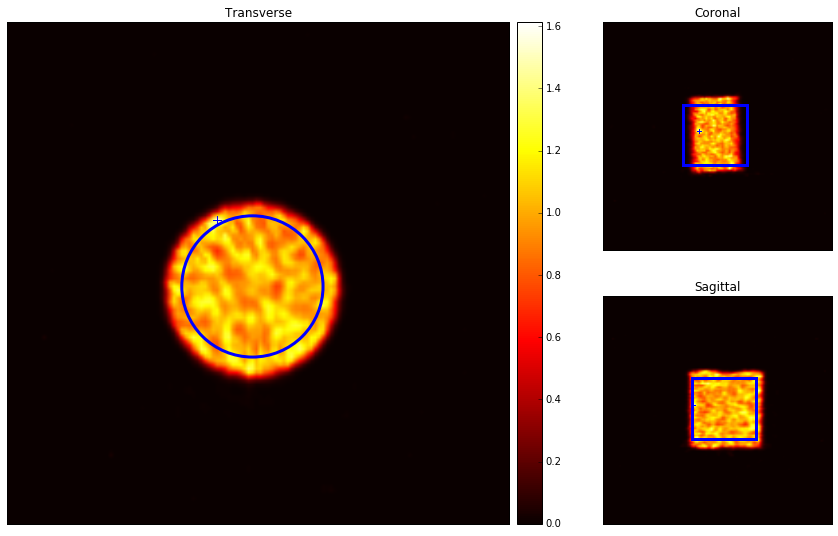

In [201]:
# MAIN INTERFACE #

# Displays SUV calculation results
def dispResults():
    mini, maxi, mean, std = get_stats(m_img, nb_pixel_x, nb_pixel_y, nb_slices,roi[0], 
                         roi[1], roi[2], roi[3]+ROI_MARGIN, roi[4]+(2*ROI_MARGIN))

    print 'Results of SUV calculation:'
    print '  - min. value: ', round(mini, 4), 'g/ml'
    print '  - max. value: ', round(maxi, 4), 'g/ml'
    print '  - mean value: ', round(mean, 4), 'g/ml'
    print '  - std deviation: ', round(std, 4), 'g/ml(', round(std/mean*100,2),'%)'

    
# Draws circle centers
def redrawCenters():
    line1a[0].set_xdata([xslider.value-1,xslider.value+1])
    line1a[0].set_ydata([zslider.value,zslider.value])
    line1b[0].set_xdata([xslider.value,xslider.value])
    line1b[0].set_ydata([zslider.value-1,zslider.value+1])
    line2a[0].set_xdata([yslider.value-1,yslider.value+1])
    line2a[0].set_ydata([zslider.value,zslider.value])
    line2b[0].set_xdata([yslider.value,yslider.value])
    line2b[0].set_ydata([zslider.value-1,zslider.value+1])
    line3a[0].set_xdata([xslider.value-1,xslider.value+1])
    line3a[0].set_ydata([yslider.value,yslider.value])
    line3b[0].set_xdata([xslider.value,xslider.value])
    line3b[0].set_ydata([yslider.value-1,yslider.value+1])
        
def refreshPlot(b):    
    minv = minslider.value
    maxv = maxslider.value
    if (minv>maxv):
        print "Erreur: min > max"
    else:
        im1.set_data(m_img[:,yslider.value,:])
        im1.set_clim(vmin=minv, vmax=maxv)
        im2.set_data(m_img[:,:,xslider.value])
        im2.set_clim(vmin=minv, vmax=maxv)
        im3.set_data(m_img[zslider.value,:,:])
        im3.set_clim(vmin=minv, vmax=maxv)
    redrawCenters()
    display.clear_output(wait=True)
    display.display(fig)
    dispResults()
  
# Plot size
plt.rcParams['figure.figsize'] = (15,9)

# min, max of main image:
_min, _max = np.amin(m_img), np.amax(m_img)

# Ipywidgets:
minslider  = FloatSlider(value=_min, min=_min, max=_max, 
                         step=(_max-_min)/100, description='min', width='40%')
maxslider  = FloatSlider(value=_max, min=_min, max=_max*1.5, 
                         step=(_max-_min)/100, description='max', width='40%')

xslider = IntSlider(value=int(nb_pixel_x/2), min=0, max=nb_pixel_x-1, 
                    step=1, description="x",width='40%')
yslider = IntSlider(value=int(nb_pixel_y/2), min=0, max=nb_pixel_y-1, 
                    step=1, description="y",width='40%')
zslider = IntSlider(value=int(nb_slices/2), min=0, max=nb_slices-1, 
                    step=1, description="z",width='40%')

refresh_button = Button(description="Refresh!", width='30%') #, height='100px'
refresh_button.on_click(refreshPlot)

items1 = [
    Label(value="Visualization window:", width='90%'),
    minslider,
    maxslider,
    Label(value=". ", width='90%'),
    Label(value="View slices", width='90%'),
    xslider,
    yslider,
    zslider,
    Label(value=". ", width='90%'),
 ]
items2 = [
    refresh_button,
]

box1 = Box(children=items1, layout=box_layout_std)
box2 = Box(children=items2, layout=box_layout_right)
display.display(box1)
display.display(box2)

# Plots the images:
fig = plt.figure()
gs = gridspec.GridSpec(2, 3)

max_pos = ndimage.measurements.maximum_position(m_img)
xslider.value = max_pos[2]
yslider.value = max_pos[1]
zslider.value = max_pos[0]

ax1 = fig.add_subplot(gs[0,2])
im1 = ax1.imshow(m_img[:,yslider.value,:], cmap="hot", vmin = _min, vmax = _max)
ax1.set_title('Coronal')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.axes.autoscale(False)

ax2 = fig.add_subplot(gs[1,2])
im2 = ax2.imshow(m_img[:,:,xslider.value], cmap="hot", vmin = _min, vmax = _max)
ax2.set_title('Sagittal')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.autoscale(False)

ax3 = fig.add_subplot(gs[:,:-1])
im3 = ax3.imshow(m_img[zslider.value,:,:], cmap="hot", vmin = _min, vmax = _max)
ax3.set_title('Transverse')
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
ax3.axes.autoscale(False)

roi = findPhantom(m_img, nb_pixel_x, nb_pixel_y, nb_slices, THRESHOLD_PHANT)

try:
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im3, cax=cax3)
    line1a = ax1.axes.plot([xslider.value-1,xslider.value+1], 
                  [zslider.value,zslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line1b = ax1.axes.plot([xslider.value,xslider.value], 
                  [zslider.value-1,zslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    line2a = ax2.axes.plot([yslider.value-1,yslider.value+1], 
                  [zslider.value,zslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line2b = ax2.axes.plot([yslider.value,yslider.value], 
                  [zslider.value-1,zslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    line3a = ax3.axes.plot([xslider.value-1,xslider.value+1], 
                  [yslider.value,yslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line3b = ax3.axes.plot([xslider.value,xslider.value], 
                  [yslider.value-1,yslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    c1 = plt.Circle((roi[0], roi[1]), roi[3]+ROI_MARGIN, fill=False, 
                      color='blue', linewidth=3)
    ax3.axes.add_patch(c1)
    r1 = plt.Rectangle((roi[0]-roi[3]-ROI_MARGIN, roi[2]-roi[4]/2-ROI_MARGIN), 
                      (roi[3]+ROI_MARGIN)*2, roi[4]+2*ROI_MARGIN, fill=False, 
                      color='blue', linewidth=3)
    ax1.axes.add_patch(r1)
    r2 = plt.Rectangle((roi[1]-roi[3]-ROI_MARGIN, roi[2]-roi[4]/2-ROI_MARGIN), 
                      (roi[3]+ROI_MARGIN)*2, roi[4]+2*ROI_MARGIN, fill=False, 
                      color='blue', linewidth=3)
    ax2.axes.add_patch(r2)
except Error: 
    print 'Error!'

dispResults()





# Remarks:

